# Mini Example for Elvis

### Import the module

Make the modules available for the Notebook

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

Import the ConfigBuilder and the simulate method

In [3]:
from elvis.config import ElvisConfigBuilder
from elvis.simulate import simulate

### Set up parameters for the simulation

#### Time parameters
* The start and end date are either of type datetime.datetime or as a str in format: '%y-%m-%d %H:%M:%S'.<br/><br/>
* The resolution (time in between two time steps) is either given as datetime.timedelta or as a str in format: '%H:%M:%S'<br/><br/>
* The time parameters are then put into a tuple in following order:<br/>
(start date, end date, resolution).

In [4]:
import datetime

start_date = '2020-01-01 20:00:00' # format: '%y-%m-%d %H:%M:%S'
end_date = datetime.datetime(2020, 1, 7, 19, 0)
resolution = '01:0:0'
time_params = (start_date, end_date, resolution)

#### Charging Events

Charging events in the config class are class objects of the evlis class ChargingEvents. The ConfigBuilder contains a method in order to generate instances of that class with an arrival distribution and the number of charging_events per week.<br/>

##### Comment:
As of now when using an arrival distribution only an hourly format for 1 week (168 values) is accepted. The arrival distribution starts at a Monday at 0:00.

In [5]:
num_charging_events = 5

arrival_distribution = [0 for x in range(168)] # create a list with 168 entries (all 0)
arrival_distribution[8] = 1 # mondays at 8 o clock cars arrive
arrival_distribution[10] = 1 # modays at 10 o clock cars arrive

#### Infrastructure Design

The infrastructure design is assumed to be a tree it is passed as a nested dict structure. <br/>
Nodes in the tree structure are described as a dict with the following keys:
* id: str (not necessary anymore)
* max_power: float/int (maximal power that is allowed to pass that node)
* min_power: float/int (minimal power that must go through the node if the power is not 0)
* children*: list (containing dicts for each child of the previous node, excluded in connection point dicts)

There are three types of nodes in the tree structure: transformers, charging points and connection points. Children of
a transformer always are charging points. Children of charging points always are connection points. The infrastructure design always starts with a dict for the transformer.


*The children key is always named after the node type of its children. For a transformer: charging_points, for a charging_point. Connection point dicts do not contain a children key.

In [6]:
infrastructure = {'transformers': [{'id': 'transformer1', 'max_power': 100, 'min_power': 10, 'charging_points': [{'id': 'charging_point1', 'max_power': 10, 'min_power': 1, 'connection_points': [{'id': 'connection_point1', 'max_power': 5, 'min_power': 0.5}, {'id': 'connection_point2', 'max_power': 5, 'min_power': 0.5}]}, {'id': 'charging_point2', 'max_power': 10, 'min_power': 1, 'connection_points': [{'id': 'connection_point3', 'max_power': 5, 'min_power': 0.5}, {'id': 'connection_point4', 'max_power': 5, 'min_power': 0.5}]}]}]}


#### Other parameters

* queue_length: Maximal number of cars that wait at the infrastructure if no connection point is available. The connect to a connection point if one becomes available before their leaving time is reached.
* disconnect_by_time: Decision variable when to disconnect a car from a connection point. <br/>
True: The cars disconnect once their leaving time is reached in total disregard of the current SOC. As a result the connection point might be blocked even though the car is fully charged.<br/>
False: The cars disconnect when their SOC target is reached or their leaving time is reached whatever comes first.
* scheduling_policy: The policy that assigns the power to the cars. Can be passed as a str (UC, FCFS, DF, OPT) or as an instance of the schduling policy classes (see sched/schedulers.py).

In [7]:
queue_length = 2 # optional as per default: 0
disconnect_by_time = True # as per default: True
scheduling_policy = 'FCFS' # only UC and FCFS are implemented

#### Not implemented

In [8]:
emissions_scenario = None
renewables_scenario = None
vehicle_types = None
opening_hours = None
preload = None

### Assign values to the ConfigBuilder

The with_VARIABLE-NAME methods are used to assign either new values to a ConfigBuilder or to simulate a config with some variables changed.<br/>
builder.build() return an instance of ElvisConfig based on the values of the Builder instance.

In [26]:
builder = ElvisConfigBuilder()

# assign time_params
builder.with_time_params(time_params)

# Methods can be chained
builder.with_queue_length(queue_length).with_scheduling_policy(scheduling_policy).with_disconnect_by_time(disconnect_by_time).with_num_charging_events(num_charging_events)

# The with_charging_events method accepts a list of ChargingEvent instances or a list of floats from which it 
# creates ChargingEvent instances. In order to allow for that other parameters (num_charging_events, time_params) must
# be set.
builder.with_charging_events(arrival_distribution)

builder.with_infrastructure(infrastructure)

config = builder.build()

### Simulate

The simulate method receives a config and performs the simulation. It returns an instance of class ElvisResult containing the results of the simulation.

In [27]:
results = simulate(config)

### Create a load profile from Result

The power assigned to each conenction point is stored in the field power_connection_points. It is of type dict with the IDs of the connection points as keys and lists containing floats of the assigned powers of those connection points are implemented. This allows already though to create a load profile.

In [28]:
import pandas as pd

df = pd.DataFrame.from_dict(results.power_connection_points)
df['total_load'] = df.sum(axis=1)

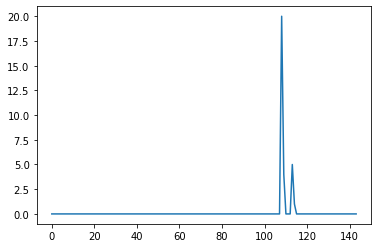

In [29]:
df.total_load.plot()